### Ethnicolr: NC Voter Registration Name Model For Hispanic/Non-Hispanic

We build new LSTM models based on NC data. We start by assuming y = concatenation of ethnic code and race code. We remove U and also UN --- assuming they are 'missing at random.' This gives us 12 categories.


In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.5.0
2.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
NGRAMS = (2, 3)
SAMPLE = 1000000
EPOCHS = 15

# Florida voter
df = pd.read_csv('/opt/data/nc_voter/nc_voter_name_gender_race_ethnic_age.csv', usecols=['last_name', 'first_name', 'race_code', 'ethnic_code'], nrows=SAMPLE * 2)
df.dropna(subset=['first_name', 'last_name'], inplace=True)

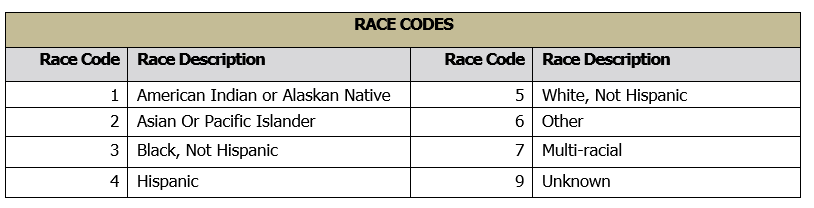

### Drop U and UN from race and ethnic.

In [4]:
df.drop(df[(df.race_code=='U')|(df.ethnic_code=='UN')].index, inplace=True)
df.head()

,last_name,first_name,race_code,ethnic_code
0,AABEL,EVELYN,W,NL
2,AARON,CLAUDIA,W,NL
6,AARON,SANDRA,W,HL
7,AARON,WILLIE,W,NL
8,AARONSON,GENA,W,NL


In [5]:
df.groupby(['race_code', 'ethnic_code']).size()

race_code  ethnic_code
A          HL                 149
           NL               10142
B          HL                1497
           NL              266127
I          HL                 157
           NL                5284
M          HL                2634
           NL                5054
O          HL               18580
           NL               17627
W          HL               10598
           NL             1210076
dtype: int64

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
sdf = df.sample(SAMPLE, random_state=21)
sdf.head()

,last_name,first_name,race_code,ethnic_code
61254,MADARASZ,AGNES,W,NL
1205421,ESTEP,DONNA,W,NL
1348373,MINAHAN,SHELBY,W,NL
13816,BUSH,DAVID,W,NL
1051654,RODRIGUEZ,ROBERT,O,NL


In [8]:
# Additional features
sdf['first_name'] = sdf.first_name.str.title()
sdf['last_name'] = sdf.last_name.str.title()

rdf = sdf.groupby('ethnic_code').agg({'first_name': 'count'})
rdf

,first_name
ethnic_code,
HL,28736
NL,971264


In [9]:
rdf.to_csv('./nc_voter_reg/lstm/nc_name_hispanic.csv', columns=[])

## Preprocessing the input data

In [10]:
%%time
# concat last name and first name
sdf['last_name_first_name'] = sdf['last_name'] + ' ' + sdf['first_name']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=10, ngram_range=NGRAMS, lowercase=False) 
a = vect.fit_transform(sdf.last_name_first_name)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)

num_words = 11666
CPU times: user 49min 30s, sys: 1.31 s, total: 49min 32s
Wall time: 49min 47s


In [11]:
vocab

{'Ma': 2393,
 'ad': 4084,
 'da': 5050,
 'ar': 4350,
 'ra': 9252,
 'as': 4379,
 'sz': 9987,
 'z ': 11438,
 ' A': 2,
 'Ag': 593,
 'gn': 6202,
 'ne': 8171,
 'es': 5717,
 'Mad': 2398,
 'ada': 4087,
 'dar': 5066,
 'ara': 4353,
 'ras': 9273,
 'asz': 4405,
 'sz ': 9988,
 'z A': 11439,
 ' Ag': 11,
 'Agn': 600,
 'gne': 6205,
 'nes': 8193,
 'Es': 1408,
 'st': 9929,
 'te': 10082,
 'ep': 5669,
 'p ': 8983,
 ' D': 51,
 'Do': 1173,
 'on': 8739,
 'nn': 8304,
 'na': 8096,
 'Est': 1420,
 'ste': 9935,
 'tep': 10101,
 'ep ': 5670,
 'p D': 8987,
 ' Do': 60,
 'Don': 1186,
 'onn': 8756,
 'nna': 8307,
 'Mi': 2467,
 'in': 6857,
 'ah': 4166,
 'ha': 6333,
 'an': 4293,
 'n ': 8044,
 ' S': 238,
 'Sh': 3217,
 'he': 6381,
 'el': 5577,
 'lb': 7456,
 'by': 4718,
 'Min': 2478,
 'ina': 6860,
 'nah': 8106,
 'aha': 4169,
 'han': 6350,
 'an ': 4294,
 'n S': 8063,
 ' Sh': 242,
 'She': 3219,
 'hel': 6393,
 'elb': 5581,
 'lby': 7465,
 'Bu': 911,
 'us': 10667,
 'sh': 9794,
 'h ': 6290,
 'Da': 1083,
 'av': 4451,
 'vi': 10808,


In [12]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    ngrams = (ngramRange[0], ngramRange[1] + 1)
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [13]:
%%time
def find_ngrams(text, ngrams):
    a = range_ngrams(text, ngrams)
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.last_name_first_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.ethnic_code.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Max feature len = 37, Avg. feature len = 12
CPU times: user 1min 59s, sys: 544 ms, total: 2min
Wall time: 2min 1s


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [14]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 25 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

800000 train sequences
200000 test sequences
Pad sequences (samples x time)
X_train shape: (800000, 25)
X_test shape: (200000, 25)
2 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (800000, 2)
y_test shape: (200000, 2)


In [15]:
print('Build model...')

if False:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
if True:
    embedding_vecor_length = 50
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            583300    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 641,534
Trainable params: 641,534
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
%%time
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/15
22500/22500 [==============================] - 632s 27ms/step - loss: 0.0844 - accuracy: 0.9759 - val_loss: 0.0703 - val_accuracy: 0.9791
Epoch 2/15
22500/22500 [==============================] - 616s 27ms/step - loss: 0.0708 - accuracy: 0.9786 - val_loss: 0.0691 - val_accuracy: 0.9796
Epoch 3/15
22500/22500 [==============================] - 608s 27ms/step - loss: 0.0670 - accuracy: 0.9796 - val_loss: 0.0683 - val_accuracy: 0.9798
Epoch 4/15
22500/22500 [==============================] - 601s 27ms/step - loss: 0.0661 - accuracy: 0.9800 - val_loss: 0.0686 - val_accuracy: 0.9796
Epoch 5/15
22500/22500 [==============================] - 601s 27ms/step - loss: 0.0635 - accuracy: 0.9806 - val_loss: 0.0680 - val_accuracy: 0.9798
Epoch 6/15
22500/22500 [==============================] - 600s 27ms/step - loss: 0.0649 - accuracy: 0.9802 - val_loss: 0.0678 - val_accuracy: 0.9797
Epoch 7/15
22500/22500 [==============================] - 602s 27ms/step - loss: 0.0637 - accurac

In [17]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.06982550770044327
Test accuracy: 0.9786800146102905


## Confusion Matrix

In [23]:
p = model.predict(X_test, verbose=2) # to predict probability
y_pred = np.argmax(p, axis=-1)
target_names = list(sdf.ethnic_code.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(conf_mat)

6250/6250 - 33s
              precision    recall  f1-score   support

          HL       0.66      0.53      0.59      5747
          NL       0.99      0.99      0.99    194253

    accuracy                           0.98    200000
   macro avg       0.82      0.76      0.79    200000
weighted avg       0.98      0.98      0.98    200000

[[  3039   2708]
 [  1556 192697]]


In [24]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

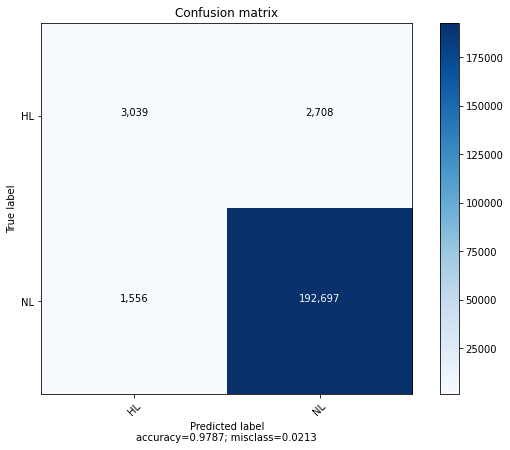

In [25]:
plot_confusion_matrix(conf_mat, target_names, normalize=False)

### Save model

In [26]:
model.save('./nc_voter_reg/lstm/nc_voter_name_hispanic_lstm.h5')

In [27]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./nc_voter_reg/lstm/nc_voter_name_vocab.csv', index=False, encoding='utf-8')